In [1]:
pip install torcheeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
  Created wheel for torcheeg: filename=torcheeg-1.1.1-py3-none-any.whl size=382578 sha256=936f6cc1970a78da5c32cee2350b

In [1]:
# ====================================================
# directory settings
# ====================================================

import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
POP_2_DIR = OUTPUT_DIR + 'pop_2_weight_oof/'
if not os.path.exists(POP_2_DIR):
    os.makedirs(POP_2_DIR)
    
POP_1_DIR = OUTPUT_DIR + 'pop_1_weight_oof/' 
if not os.path.exists(POP_1_DIR):
    os.makedirs(POP_1_DIR)

# Libraries

In [3]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Dict, List
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
# from torcheeg.models import ArjunViT
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
VERSION=2

# Config

In [4]:
# ====================================================
# CFG
# ====================================================

class CFG:
    wandb = False
    debug = False
    train=True
    apex=True
    stage1_pop1=True
    stage2_pop2=False
    VISUALIZE=True
    FREEZE=False
    SparK=False
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':20,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    print_freq=50
    num_workers = 1
    model_name = 'tf_efficientnet_b0_ns'
    optimizer='Adan'
    epochs = 5
    factor = 0.9
    patience = 2
    eps = 1e-6
    lr = 1e-3
    min_lr = 1e-6
    batch_size = 64
    weight_decay = 1e-2
    batch_scheduler=True
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7
    seed = 2024
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    target_size = 6
    num_channels = 8
    pred_cols = ['pred_seizure_vote', 'pred_lpd_vote', 'pred_gpd_vote', 'pred_lrda_vote', 'pred_grda_vote', 'pred_other_vote']
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"

# Utils

In [5]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(targets.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    return cv

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss



def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_torch(seed=CFG.seed)

# Load train data

In [6]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:]
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.


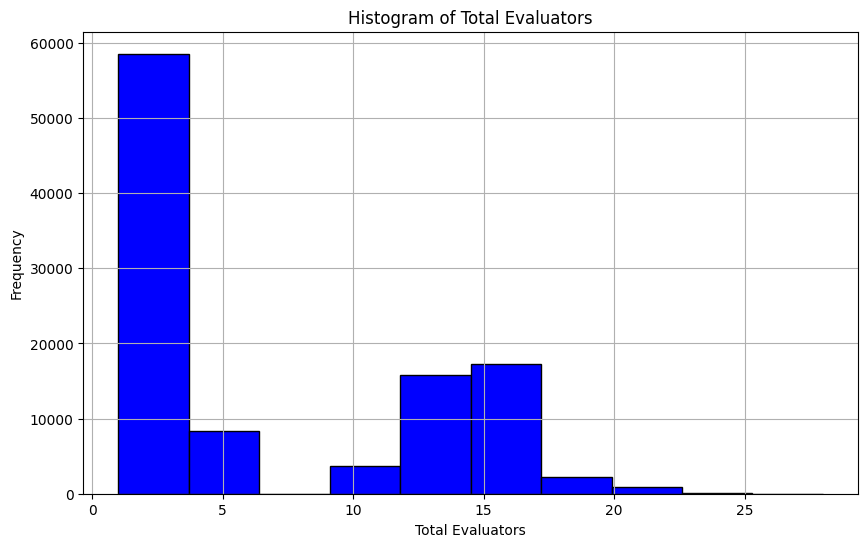

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
import scipy.signal

def eeg_from_parquet(parquet_path, display=False):
    
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-SAMPLES)//2
    eeg = eeg.iloc[offset:offset+SAMPLES]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((SAMPLES,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        # Downsampling from 200 Hz to 100 Hz
        downsampled_x = scipy.signal.resample(x, SAMPLES)
        data[:, j] = downsampled_x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(SAMPLES),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

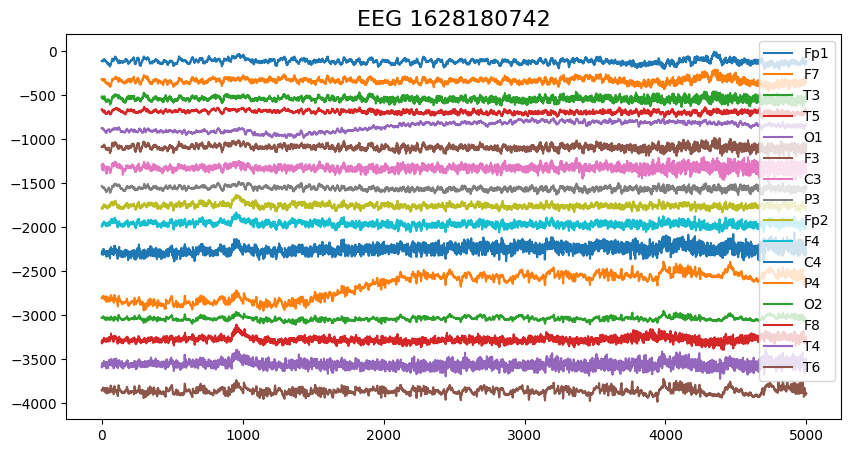

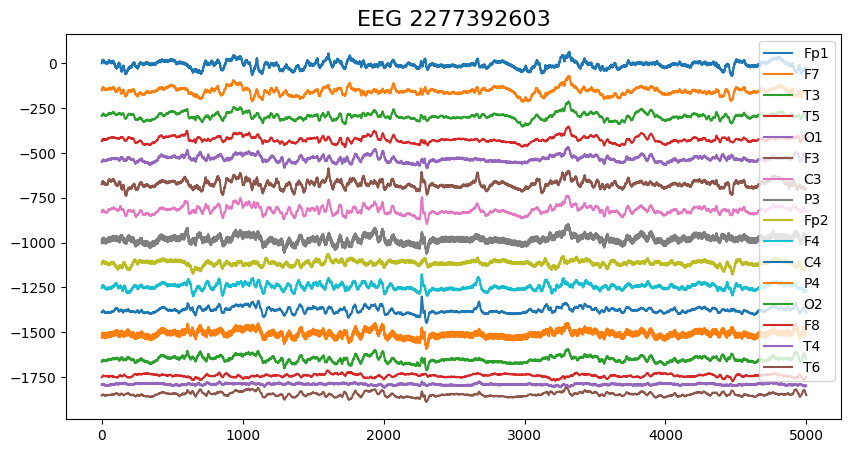

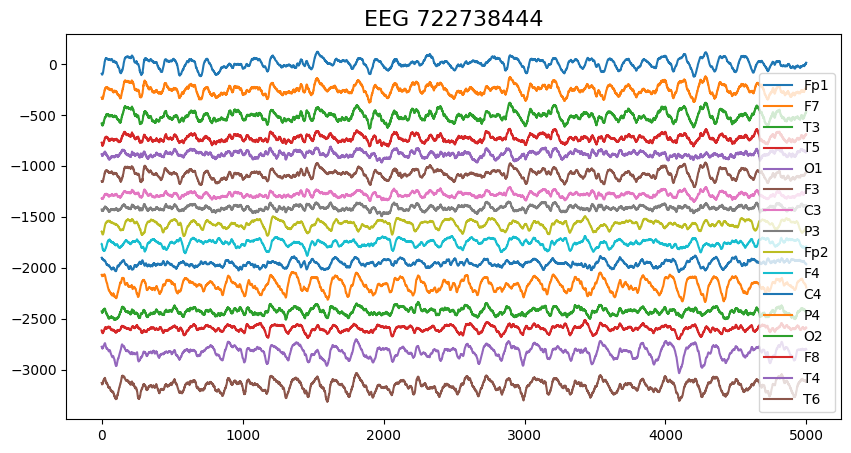

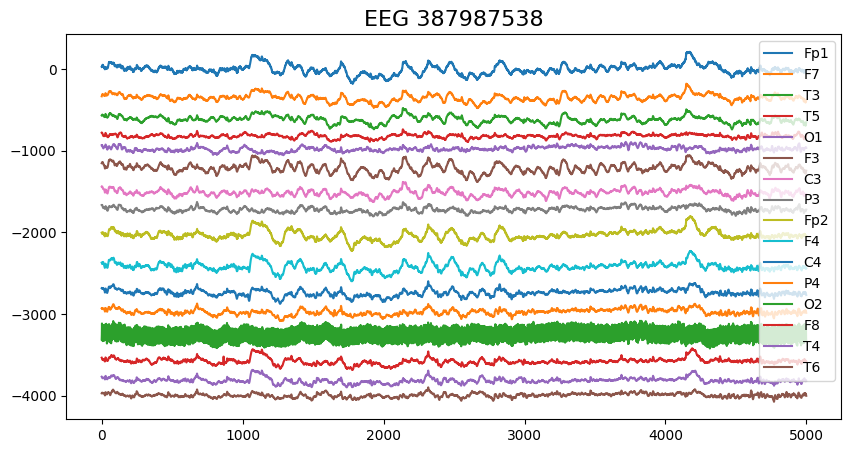

Processing 17089 eeg parquets... 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 , 135

In [9]:
SAMPLES = 5_000
CREATE_EEGS = True
# FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEATS = ['Fp1', 'F7', 'T3', 'T5', 'O1', 'F3', 'C3', 'P3', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}

raw_eegs = {}
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
            
if CREATE_EEGS: 
    for i,eeg_id in enumerate(EEG_IDS):
        if (i%100==0)&(i!=0): print(i,', ',end='') 

        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
        raw_eegs[eeg_id] = data

        if i==DISPLAY:
            if CREATE_EEGS:
                print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
            else:
                print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
                break
    
    np.save('eegs',raw_eegs)
else:
    raw_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

# Deduplicate Train EEG Id

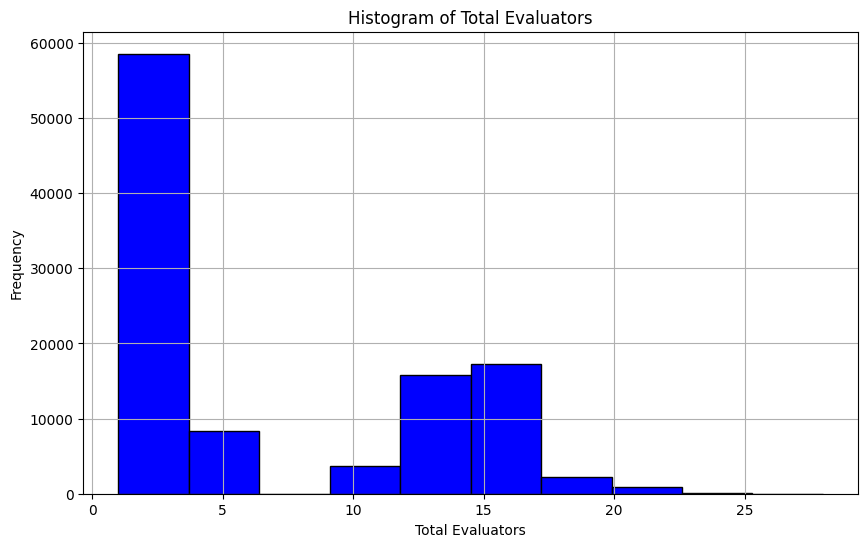

In [13]:
train = train[train['eeg_id'].isin(raw_eegs.keys())].copy()

y_data = train[TARGETS].values +  0.166666667 # Regularization value
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

train = train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

del y_data
_ = gc.collect()

# CV Scheme

In [14]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id
    
del gkf
_ = gc.collect()

# Dataset

In [15]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    # bins = np.linspace(-1, 1, classes)
    # quantized = np.digitize(mu_x, bins) - 1
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class EEGDataset(torch.utils.data.Dataset):
    def __init__(
        self, df: pd.DataFrame,
        augment: bool = False, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = raw_eegs
    ): 
        self.df = df
        self.augment = augment
        self.mode = mode
        self.eegs = eegs
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # Processing EEG signal data
        eeg_data = self.eegs[row.eeg_id]
#         sample = np.zeros((eeg_data.shape[0], len(FEATS)))  # Assuming eeg_data.shape[1] == 8 for 8 channels
        
        # Compute differences
#         for i, (start, end) in enumerate([('Fp1', 'T3'), ('T3', 'O1'), ('Fp1', 'C3'), ('C3', 'O1'), 
#                                           ('Fp2', 'C4'), ('C4', 'O2'), ('Fp2', 'T4'), ('T4', 'O2')]):
#             sample[:, i] = eeg_data[:, FEAT2IDX[start]] - eeg_data[:, FEAT2IDX[end]]
        
        sample = self.process_sample(eeg_data)
        
        samples = torch.from_numpy(sample).float()
        samples = samples.permute(1, 0)
        
        if self.mode != 'test':
            label = row[TARGETS]  # Assuming 'TARGETS' is defined somewhere as the label column name
            label = torch.tensor(label).float()  
            return samples, label
        else:
            return samples
    
    def process_sample(self, sample):
        # Normalize the sample data
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        sample = np.clip(sample, -1024, 1024)
        sample = np.nan_to_num(sample, nan=0)
        sample = butter_lowpass_filter(sample)
        sample = quantize_data(sample, 1)
        return sample

    

In [16]:
dataset = EEGDataset(train, augment=True, mode="train")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

samples, label = dataset[0]

print(f"Samples shape: {samples.shape}")
print(f"Label shape: {label.shape}")

del dataset, samples, label
_ = gc.collect()

Samples shape: torch.Size([16, 5000])
Label shape: torch.Size([6])


# Model

In [18]:


#%% The proposed ATCNet model
class ATCNet(nn.Module):
    def __init__(self, n_classes, in_chans=22, in_samples=1125, n_windows=5, attention='mha',
                 eegn_F1=16, eegn_D=2, eegn_kernelSize=64, eegn_poolSize=7, eegn_dropout=0.3,
                 tcn_depth=2, tcn_kernelSize=4, tcn_filters=32, tcn_dropout=0.3, tcn_activation='relu',
                 fuse='average'):
        super(ATCNet, self).__init__()

        self.n_classes = n_classes
        self.in_chans = in_chans
        self.in_samples = in_samples
        self.n_windows = n_windows
        self.attention = attention
        self.eegn_F1 = eegn_F1
        self.eegn_D = eegn_D
        self.eegn_kernelSize = eegn_kernelSize
        self.eegn_poolSize = eegn_poolSize
        self.eegn_dropout = eegn_dropout
        self.tcn_depth = tcn_depth
        self.tcn_kernelSize = tcn_kernelSize
        self.tcn_filters = tcn_filters
        self.tcn_dropout = tcn_dropout
        self.tcn_activation = tcn_activation
        self.fuse = fuse

        self.conv_block = Conv_block(in_chans=self.in_chans, F1=self.eegn_F1, D=self.eegn_D,
                                     kernLength=self.eegn_kernelSize, poolSize=self.eegn_poolSize,
                                     dropout=self.eegn_dropout)

        self.mha_block = MultiHeadAttention()
        self.tcn_block = TCN_block(input_dimension=self.eegn_F1 * self.eegn_D, depth=self.tcn_depth,
                                   kernel_size=self.tcn_kernelSize, filters=self.tcn_filters,
                                   dropout=self.tcn_dropout, activation=self.tcn_activation)

        self.linear = nn.Linear(self.tcn_filters, self.n_classes)

    def forward(self, x):
        x = self.conv_block(x)

        sw_concat = []
        for i in range(self.n_windows):
            st = i
            end = x.shape[2] - self.n_windows + i + 1
            x_window = x[:, :, st:end]

            if self.attention is not None:
                x_window = attention_block(x_window, self.attention)

            x_window = self.tcn_block(x_window)
            x_window = x_window[:, -1, :]

            sw_concat.append(x_window)

        if self.fuse == 'average':
            if len(sw_concat) > 1:
                sw_concat = torch.mean(torch.stack(sw_concat), dim=0)
            else:
                sw_concat = sw_concat[0]
        elif self.fuse == 'concat':
            sw_concat = torch.cat(sw_concat, dim=1)

        out = self.linear(sw_concat)
        return out

In [20]:
iot = torch.randn(2, 8, 5_000)
model = ATCNet(in_samples=SAMPLES,
                 in_chans=16,
                 n_classes=6)

output = model(iot)
print(output.shape)

del iot, model, output
gc.collect()
torch.cuda.empty_cache()

NameError: name 'Conv_block' is not defined

# Adan Optimizer

In [17]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models[J]. arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for computing 
            running averages of gradient and its norm. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve 
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip 
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.98, 0.92, 0.99), eps=1e-8,
                 weight_decay=0.2, max_grad_norm=0.0, no_prox=False):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm, no_prox=no_prox)
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        """
            Performs a single optimization step.
        """
        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'], device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(max_grad_norm / (global_grad_norm + group['eps']), max=1.0)
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1 ** group['step']

            bias_correction2 = 1.0 - beta2 ** group['step']

            bias_correction3 = 1.0 - beta3 ** group['step']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if 'pre_grad' not in state or group['step'] == 1:
                    state['pre_grad'] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_diff']
                diff = grad - state['pre_grad']

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(group['eps'])
                update = ((exp_avg / bias_correction1 + beta2 * exp_avg_diff / bias_correction2)).div_(denom)

                if group['no_prox']:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                    p.add_(update, alpha=-group['lr'])
                else:
                    p.add_(update, alpha=-group['lr'])
                    p.data.div_(1 + group['lr'] * group['weight_decay'])

                state['pre_grad'] = copy_grad

# Helper functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        batch_size = y.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds= model(X)
            loss = criterion(F.log_softmax(y_preds, dim=1), y)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (X, y) in enumerate(valid_loader):
        X = X.to(device)
        y = y.to(device)
        batch_size = y.size(0)
        with torch.no_grad():
            y_preds = model(X)
            loss = criterion(F.log_softmax(y_preds, dim=1), y)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train Loop

In [21]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, directory):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if CFG.stage1_pop1:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 10)].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[ CFG.target_cols].values
    
    train_dataset = EEGDataset(train_folds, augment=True, mode="train")
    valid_dataset = EEGDataset(valid_folds, augment=False, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = ArjunViT(chunk_size=SAMPLES,
                 t_patch_size=50,
                 num_electrodes=16,
                 num_classes=6,
                 embed_dropout=0.3,
                 dropout=0.3,
                 depth=10,
                 heads=12)
    
    if CFG.stage2_pop2:
        model_weight = POP_1_DIR + f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth"
        checkpoint = torch.load(model_weight, map_location=device)
        model.load_state_dict(checkpoint["model"])
    # CPMP: wrap the model to use all GPUs
    #model = nn.DataParallel(model, device_ids=[0, 1])
    model.to(device)
    
    def build_optimizer(cfg, model, device):
        lr = cfg.lr
        # lr = default_configs["lr"]
        if cfg.optimizer == "SAM":
            base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
            optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
        elif cfg.optimizer == "Ranger21":
            optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
            num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
        elif cfg.optimizer == "SGD":
            optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
        elif cfg.optimizer == "Adam":
            optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        elif cfg.optimizer == "Lion":
            optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
        elif cfg.optimizer == "Adan":
            optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
        return optimizer_model
    
    optimizer = build_optimizer(CFG, model, device)
    
    # ====================================================
    # scheduler
    # ====================================================
    # ====================================================

    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        elif CFG.scheduler=='OneCycleLR':
            steps_per_epoch=len(train_loader),
            scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, final_div_factor=100)
        return scheduler
    
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.KLDivLoss(reduction="batchmean")

    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
            # CPMP: save the original model. It is stored as the module attribute of the DP model.
            if CFG.stage1_pop1:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
            else:
                
                torch.save({'model': model.state_dict(),
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
    if CFG.stage1_pop1:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
                             map_location=torch.device('cpu'))['predictions']
    else:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.target_cols] = valid_labels 
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, best_score

In [22]:
if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_1_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage1: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage1: {np.mean(scores)}')
        oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/1335] Elapsed 0m 1s (remain 25m 53s) Loss: 1.0139(1.0139) Grad: 95179.5625  LR: 0.00004002  
Epoch: [1][50/1335] Elapsed 0m 14s (remain 6m 16s) Loss: 0.8804(0.9424) Grad: 43127.1211  LR: 0.00009458  
Epoch: [1][100/1335] Elapsed 0m 29s (remain 5m 55s) Loss: 0.8092(0.8988) Grad: 43384.6016  LR: 0.00024219  
Epoch: [1][150/1335] Elapsed 0m 43s (remain 5m 39s) Loss: 0.8411(0.8799) Grad: 31635.5293  LR: 0.00045057  
Epoch: [1][200/1335] Elapsed 0m 57s (remain 5m 24s) Loss: 0.8233(0.8698) Grad: 38212.6914  LR: 0.00067413  
Epoch: [1][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.6612(0.8494) Grad: 36754.9414  LR: 0.00086399  
Epoch: [1][300/1335] Elapsed 1m 25s (remain 4m 52s) Loss: 0.6758(0.8251) Grad: 43503.1953  LR: 0.00097860  
Epoch: [1][350/1335] Elapsed 1m 38s (remain 4m 37s) Loss: 0.6712(0.8036) Grad: 36599.5430  LR: 0.00099998  
Epoch: [1][400/1335] Elapsed 1m 52s (remain 4m 23s) Loss: 0.5991(0.7858) Grad: 31027.8066  LR: 0.00099971  
Epoch: [1][450/1335] Elapsed 2m 

Epoch 1 - avg_train_loss: 0.6419  avg_val_loss: 0.7097  time: 469s
Epoch 1 - Save Best valid loss: 0.7097 Model


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 1.1255(0.7097) 
Epoch: [2][0/1335] Elapsed 0m 0s (remain 12m 17s) Loss: 0.5463(0.5463) Grad: 79872.3594  LR: 0.00093953  
Epoch: [2][50/1335] Elapsed 0m 14s (remain 6m 13s) Loss: 0.5663(0.5164) Grad: 68628.5156  LR: 0.00093349  
Epoch: [2][100/1335] Elapsed 0m 28s (remain 5m 51s) Loss: 0.5672(0.5055) Grad: 44273.6797  LR: 0.00092718  
Epoch: [2][150/1335] Elapsed 0m 43s (remain 5m 37s) Loss: 0.4434(0.5080) Grad: 42634.0469  LR: 0.00092062  
Epoch: [2][200/1335] Elapsed 0m 57s (remain 5m 21s) Loss: 0.5106(0.5054) Grad: 60934.3125  LR: 0.00091380  
Epoch: [2][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.4855(0.5019) Grad: 55545.2500  LR: 0.00090672  
Epoch: [2][300/1335] Elapsed 1m 25s (remain 4m 52s) Loss: 0.5088(0.4981) Grad: 74648.8281  LR: 0.00089939  
Epoch: [2][350/1335] Elapsed 1m 39s (remain 4m 37s) Loss: 0.5129(0.4962) Grad: 65049.3672  LR: 0.00089182  
Epoch: [2][400/1335] Elapsed 1m 53s (remain 4m 23s) Loss: 0.4986(0.4931)

Epoch 2 - avg_train_loss: 0.4572  avg_val_loss: 0.7275  time: 466s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8605(0.7275) 
Epoch: [3][0/1335] Elapsed 0m 0s (remain 13m 7s) Loss: 0.3833(0.3833) Grad: 54214.6641  LR: 0.00070051  
Epoch: [3][50/1335] Elapsed 0m 14s (remain 6m 8s) Loss: 0.3484(0.4157) Grad: 39127.7500  LR: 0.00068911  
Epoch: [3][100/1335] Elapsed 0m 28s (remain 5m 49s) Loss: 0.3883(0.4096) Grad: 40968.2305  LR: 0.00067759  
Epoch: [3][150/1335] Elapsed 0m 42s (remain 5m 36s) Loss: 0.4930(0.4112) Grad: 62615.1523  LR: 0.00066596  
Epoch: [3][200/1335] Elapsed 0m 57s (remain 5m 23s) Loss: 0.4739(0.4105) Grad: 87627.1719  LR: 0.00065423  
Epoch: [3][250/1335] Elapsed 1m 11s (remain 5m 8s) Loss: 0.3824(0.4078) Grad: 56296.7070  LR: 0.00064241  
Epoch: [3][300/1335] Elapsed 1m 25s (remain 4m 53s) Loss: 0.4607(0.4062) Grad: 67054.2578  LR: 0.00063050  
Epoch: [3][350/1335] Elapsed 1m 39s (remain 4m 39s) Loss: 0.3085(0.4040) Grad: 41105.3164  LR: 0.00061851  
Epoch: [3][400/1335] Elapsed 1m 53s (remain 4m 24s) Loss: 0.3610(0.4012) G

Epoch 3 - avg_train_loss: 0.3795  avg_val_loss: 0.7506  time: 468s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8593(0.7506) 
Epoch: [4][0/1335] Elapsed 0m 0s (remain 12m 39s) Loss: 0.3398(0.3398) Grad: 59085.8945  LR: 0.00037703  
Epoch: [4][50/1335] Elapsed 0m 15s (remain 6m 18s) Loss: 0.3705(0.3557) Grad: 71162.1172  LR: 0.00036507  
Epoch: [4][100/1335] Elapsed 0m 29s (remain 5m 59s) Loss: 0.3491(0.3541) Grad: 55773.7969  LR: 0.00035319  
Epoch: [4][150/1335] Elapsed 0m 43s (remain 5m 39s) Loss: 0.3331(0.3532) Grad: 61161.5391  LR: 0.00034140  
Epoch: [4][200/1335] Elapsed 0m 57s (remain 5m 23s) Loss: 0.3162(0.3517) Grad: 59103.4023  LR: 0.00032971  
Epoch: [4][250/1335] Elapsed 1m 11s (remain 5m 9s) Loss: 0.4029(0.3521) Grad: 71038.1719  LR: 0.00031813  
Epoch: [4][300/1335] Elapsed 1m 25s (remain 4m 55s) Loss: 0.2816(0.3507) Grad: 47234.1797  LR: 0.00030666  
Epoch: [4][350/1335] Elapsed 1m 40s (remain 4m 40s) Loss: 0.3467(0.3498) Grad: 57085.1289  LR: 0.00029530  
Epoch: [4][400/1335] Elapsed 1m 53s (remain 4m 25s) Loss: 0.2874(0.3488)

Epoch 4 - avg_train_loss: 0.3357  avg_val_loss: 0.7515  time: 472s


EVAL: [166/167] Elapsed 1m 34s (remain 0m 0s) Loss: 0.8479(0.7515) 
Epoch: [5][0/1335] Elapsed 0m 0s (remain 12m 26s) Loss: 0.3973(0.3973) Grad: 73954.8281  LR: 0.00010548  
Epoch: [5][50/1335] Elapsed 0m 14s (remain 6m 10s) Loss: 0.2702(0.3238) Grad: 58120.0742  LR: 0.00009801  
Epoch: [5][100/1335] Elapsed 0m 29s (remain 5m 56s) Loss: 0.2951(0.3181) Grad: 50242.0156  LR: 0.00009078  
Epoch: [5][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.2720(0.3216) Grad: 66294.6250  LR: 0.00008381  
Epoch: [5][200/1335] Elapsed 0m 57s (remain 5m 22s) Loss: 0.2247(0.3204) Grad: 72349.0625  LR: 0.00007709  
Epoch: [5][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.2509(0.3186) Grad: 46111.6445  LR: 0.00007063  
Epoch: [5][300/1335] Elapsed 1m 25s (remain 4m 52s) Loss: 0.3068(0.3196) Grad: 64053.0078  LR: 0.00006443  
Epoch: [5][350/1335] Elapsed 1m 39s (remain 4m 38s) Loss: 0.2943(0.3178) Grad: 61788.0547  LR: 0.00005851  
Epoch: [5][400/1335] Elapsed 1m 53s (remain 4m 24s) Loss: 0.3000(0.3171)

Epoch 5 - avg_train_loss: 0.3163  avg_val_loss: 0.7642  time: 469s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8957(0.7642) 


========== fold: 0 result ==========
Score with best loss weights stage1: 0.7097426751133208
========== fold: 1 training ==========


Epoch: [1][0/1335] Elapsed 0m 0s (remain 12m 34s) Loss: 0.8818(0.8818) Grad: 56337.1172  LR: 0.00004002  
Epoch: [1][50/1335] Elapsed 0m 14s (remain 6m 2s) Loss: 0.7782(0.8651) Grad: 38898.5391  LR: 0.00009458  
Epoch: [1][100/1335] Elapsed 0m 28s (remain 5m 47s) Loss: 0.8439(0.8576) Grad: 38910.1758  LR: 0.00024219  
Epoch: [1][150/1335] Elapsed 0m 42s (remain 5m 32s) Loss: 0.8235(0.8527) Grad: 52555.3594  LR: 0.00045057  
Epoch: [1][200/1335] Elapsed 0m 56s (remain 5m 18s) Loss: 0.7657(0.8428) Grad: 46384.4883  LR: 0.00067413  
Epoch: [1][250/1335] Elapsed 1m 10s (remain 5m 3s) Loss: 0.7738(0.8303) Grad: 42824.8555  LR: 0.00086399  
Epoch: [1][300/1335] Elapsed 1m 24s (remain 4m 49s) Loss: 0.7137(0.8163) Grad: 40420.3750  LR: 0.00097860  
Epoch: [1][350/1335] Elapsed 1m 37s (remain 4m 34s) Loss: 0.7492(0.8028) Grad: 58932.5625  LR: 0.00099998  
Epoch: [1][400/1335] Elapsed 1m 51s (remain 4m 20s) Loss: 0.6630(0.7890) Grad: 59537.6680  LR: 0.00099971  
Epoch: [1][450/1335] Elapsed 2m 6

Epoch 1 - avg_train_loss: 0.6558  avg_val_loss: 0.7269  time: 465s
Epoch 1 - Save Best valid loss: 0.7269 Model


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8090(0.7269) 
Epoch: [2][0/1335] Elapsed 0m 0s (remain 12m 14s) Loss: 0.4836(0.4836) Grad: 36690.4102  LR: 0.00093953  
Epoch: [2][50/1335] Elapsed 0m 14s (remain 6m 5s) Loss: 0.5282(0.5138) Grad: 35702.6562  LR: 0.00093349  
Epoch: [2][100/1335] Elapsed 0m 28s (remain 5m 49s) Loss: 0.4759(0.5165) Grad: 42760.3086  LR: 0.00092718  
Epoch: [2][150/1335] Elapsed 0m 42s (remain 5m 34s) Loss: 0.4804(0.5166) Grad: 40559.5547  LR: 0.00092062  
Epoch: [2][200/1335] Elapsed 0m 56s (remain 5m 18s) Loss: 0.4415(0.5136) Grad: 40015.4844  LR: 0.00091380  
Epoch: [2][250/1335] Elapsed 1m 10s (remain 5m 3s) Loss: 0.5132(0.5146) Grad: 64326.7969  LR: 0.00090672  
Epoch: [2][300/1335] Elapsed 1m 24s (remain 4m 49s) Loss: 0.5337(0.5145) Grad: 46583.7773  LR: 0.00089939  
Epoch: [2][350/1335] Elapsed 1m 38s (remain 4m 34s) Loss: 0.4603(0.5113) Grad: 51266.7852  LR: 0.00089182  
Epoch: [2][400/1335] Elapsed 1m 52s (remain 4m 20s) Loss: 0.4971(0.5073) 

Epoch 2 - avg_train_loss: 0.4734  avg_val_loss: 0.6901  time: 464s
Epoch 2 - Save Best valid loss: 0.6901 Model


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8139(0.6901) 
Epoch: [3][0/1335] Elapsed 0m 0s (remain 12m 25s) Loss: 0.3502(0.3502) Grad: 52134.2383  LR: 0.00070051  
Epoch: [3][50/1335] Elapsed 0m 14s (remain 6m 7s) Loss: 0.3927(0.4217) Grad: 67591.4766  LR: 0.00068911  
Epoch: [3][100/1335] Elapsed 0m 28s (remain 5m 50s) Loss: 0.4393(0.4239) Grad: 49729.3477  LR: 0.00067759  
Epoch: [3][150/1335] Elapsed 0m 42s (remain 5m 32s) Loss: 0.4481(0.4189) Grad: 56173.1797  LR: 0.00066596  
Epoch: [3][200/1335] Elapsed 0m 56s (remain 5m 18s) Loss: 0.3751(0.4179) Grad: 47028.3477  LR: 0.00065423  
Epoch: [3][250/1335] Elapsed 1m 10s (remain 5m 3s) Loss: 0.4398(0.4160) Grad: 67990.8438  LR: 0.00064241  
Epoch: [3][300/1335] Elapsed 1m 24s (remain 4m 49s) Loss: 0.3794(0.4130) Grad: 55314.8008  LR: 0.00063050  
Epoch: [3][350/1335] Elapsed 1m 38s (remain 4m 35s) Loss: 0.4801(0.4131) Grad: 67565.0859  LR: 0.00061851  
Epoch: [3][400/1335] Elapsed 1m 52s (remain 4m 20s) Loss: 0.4376(0.4127) 

Epoch 3 - avg_train_loss: 0.3950  avg_val_loss: 0.7342  time: 463s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8473(0.7342) 
Epoch: [4][0/1335] Elapsed 0m 0s (remain 12m 30s) Loss: 0.2754(0.2754) Grad: 47801.5508  LR: 0.00037703  
Epoch: [4][50/1335] Elapsed 0m 14s (remain 6m 11s) Loss: 0.3697(0.3618) Grad: 68739.5000  LR: 0.00036507  
Epoch: [4][100/1335] Elapsed 0m 28s (remain 5m 50s) Loss: 0.3645(0.3595) Grad: 58632.8281  LR: 0.00035319  
Epoch: [4][150/1335] Elapsed 0m 42s (remain 5m 34s) Loss: 0.3944(0.3585) Grad: 68273.7734  LR: 0.00034140  
Epoch: [4][200/1335] Elapsed 0m 56s (remain 5m 18s) Loss: 0.3747(0.3577) Grad: 59372.8984  LR: 0.00032971  
Epoch: [4][250/1335] Elapsed 1m 10s (remain 5m 5s) Loss: 0.4025(0.3577) Grad: 49341.1523  LR: 0.00031813  
Epoch: [4][300/1335] Elapsed 1m 24s (remain 4m 51s) Loss: 0.4354(0.3587) Grad: 89147.1953  LR: 0.00030666  
Epoch: [4][350/1335] Elapsed 1m 38s (remain 4m 36s) Loss: 0.4066(0.3574) Grad: 64391.1484  LR: 0.00029530  
Epoch: [4][400/1335] Elapsed 1m 52s (remain 4m 21s) Loss: 0.3637(0.3584)

Epoch 4 - avg_train_loss: 0.3525  avg_val_loss: 0.7753  time: 465s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.7618(0.7753) 
Epoch: [5][0/1335] Elapsed 0m 0s (remain 12m 28s) Loss: 0.2823(0.2823) Grad: 52178.5625  LR: 0.00010548  
Epoch: [5][50/1335] Elapsed 0m 14s (remain 6m 12s) Loss: 0.2891(0.3298) Grad: 66854.3672  LR: 0.00009801  
Epoch: [5][100/1335] Elapsed 0m 28s (remain 5m 53s) Loss: 0.2139(0.3292) Grad: 48060.5391  LR: 0.00009078  
Epoch: [5][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.3228(0.3351) Grad: 52201.6523  LR: 0.00008381  
Epoch: [5][200/1335] Elapsed 0m 56s (remain 5m 20s) Loss: 0.2746(0.3342) Grad: 72674.1172  LR: 0.00007709  
Epoch: [5][250/1335] Elapsed 1m 10s (remain 5m 5s) Loss: 0.3526(0.3334) Grad: 55629.5469  LR: 0.00007063  
Epoch: [5][300/1335] Elapsed 1m 24s (remain 4m 51s) Loss: 0.4337(0.3350) Grad: 55763.0078  LR: 0.00006443  
Epoch: [5][350/1335] Elapsed 1m 38s (remain 4m 36s) Loss: 0.2716(0.3339) Grad: 52204.0469  LR: 0.00005851  
Epoch: [5][400/1335] Elapsed 1m 52s (remain 4m 22s) Loss: 0.4040(0.3328)

Epoch 5 - avg_train_loss: 0.3319  avg_val_loss: 0.7745  time: 465s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6888(0.7745) 


========== fold: 1 result ==========
Score with best loss weights stage1: 0.690067659603076
========== fold: 2 training ==========


Epoch: [1][0/1335] Elapsed 0m 0s (remain 12m 39s) Loss: 1.0096(1.0096) Grad: 100576.2578  LR: 0.00004002  
Epoch: [1][50/1335] Elapsed 0m 14s (remain 6m 7s) Loss: 0.8588(0.9155) Grad: 33566.6289  LR: 0.00009458  
Epoch: [1][100/1335] Elapsed 0m 28s (remain 5m 48s) Loss: 0.7959(0.8858) Grad: 28260.2578  LR: 0.00024219  
Epoch: [1][150/1335] Elapsed 0m 42s (remain 5m 33s) Loss: 0.7949(0.8719) Grad: 38101.6836  LR: 0.00045057  
Epoch: [1][200/1335] Elapsed 0m 56s (remain 5m 19s) Loss: 0.8577(0.8627) Grad: 48467.6250  LR: 0.00067413  
Epoch: [1][250/1335] Elapsed 1m 10s (remain 5m 4s) Loss: 0.7792(0.8462) Grad: 37358.0742  LR: 0.00086399  
Epoch: [1][300/1335] Elapsed 1m 24s (remain 4m 50s) Loss: 0.6834(0.8264) Grad: 59808.4844  LR: 0.00097860  
Epoch: [1][350/1335] Elapsed 1m 38s (remain 4m 35s) Loss: 0.6029(0.8090) Grad: 42548.8359  LR: 0.00099998  
Epoch: [1][400/1335] Elapsed 1m 52s (remain 4m 20s) Loss: 0.6858(0.7923) Grad: 34756.8867  LR: 0.00099971  
Epoch: [1][450/1335] Elapsed 2m 

Epoch 1 - avg_train_loss: 0.6397  avg_val_loss: 0.7223  time: 462s
Epoch 1 - Save Best valid loss: 0.7223 Model


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.6913(0.7223) 
Epoch: [2][0/1335] Elapsed 0m 0s (remain 12m 36s) Loss: 0.4645(0.4645) Grad: 51931.9805  LR: 0.00093953  
Epoch: [2][50/1335] Elapsed 0m 14s (remain 6m 6s) Loss: 0.5057(0.4951) Grad: 40313.6953  LR: 0.00093349  
Epoch: [2][100/1335] Elapsed 0m 28s (remain 5m 52s) Loss: 0.4303(0.4942) Grad: 54447.4180  LR: 0.00092718  
Epoch: [2][150/1335] Elapsed 0m 43s (remain 5m 37s) Loss: 0.4528(0.4938) Grad: 52066.0273  LR: 0.00092062  
Epoch: [2][200/1335] Elapsed 0m 57s (remain 5m 24s) Loss: 0.5313(0.4943) Grad: 65035.4609  LR: 0.00091380  
Epoch: [2][250/1335] Elapsed 1m 12s (remain 5m 11s) Loss: 0.4027(0.4926) Grad: 36480.8945  LR: 0.00090672  
Epoch: [2][300/1335] Elapsed 1m 26s (remain 4m 57s) Loss: 0.4344(0.4894) Grad: 52982.3047  LR: 0.00089939  
Epoch: [2][350/1335] Elapsed 1m 41s (remain 4m 43s) Loss: 0.5513(0.4890) Grad: 58827.9336  LR: 0.00089182  
Epoch: [2][400/1335] Elapsed 1m 55s (remain 4m 29s) Loss: 0.5112(0.4879)

Epoch 2 - avg_train_loss: 0.4541  avg_val_loss: 0.7229  time: 478s


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 0.5598(0.7229) 
Epoch: [3][0/1335] Elapsed 0m 0s (remain 12m 37s) Loss: 0.3393(0.3393) Grad: 39503.2578  LR: 0.00070051  
Epoch: [3][50/1335] Elapsed 0m 14s (remain 6m 7s) Loss: 0.4843(0.4084) Grad: 45704.7227  LR: 0.00068911  
Epoch: [3][100/1335] Elapsed 0m 28s (remain 5m 52s) Loss: 0.3057(0.4054) Grad: 41257.6172  LR: 0.00067759  
Epoch: [3][150/1335] Elapsed 0m 43s (remain 5m 37s) Loss: 0.4033(0.4039) Grad: 64038.0117  LR: 0.00066596  
Epoch: [3][200/1335] Elapsed 0m 57s (remain 5m 23s) Loss: 0.4641(0.4032) Grad: 65286.5508  LR: 0.00065423  
Epoch: [3][250/1335] Elapsed 1m 11s (remain 5m 9s) Loss: 0.3528(0.4020) Grad: 54575.2500  LR: 0.00064241  
Epoch: [3][300/1335] Elapsed 1m 26s (remain 4m 56s) Loss: 0.3832(0.4014) Grad: 44437.8867  LR: 0.00063050  
Epoch: [3][350/1335] Elapsed 1m 40s (remain 4m 40s) Loss: 0.4964(0.3995) Grad: 57470.3086  LR: 0.00061851  
Epoch: [3][400/1335] Elapsed 1m 54s (remain 4m 26s) Loss: 0.3187(0.3976) 

Epoch 3 - avg_train_loss: 0.3788  avg_val_loss: 0.7793  time: 477s


EVAL: [166/167] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5817(0.7793) 
Epoch: [4][0/1335] Elapsed 0m 0s (remain 12m 52s) Loss: 0.4154(0.4154) Grad: 63809.8633  LR: 0.00037703  
Epoch: [4][50/1335] Elapsed 0m 15s (remain 6m 25s) Loss: 0.3697(0.3555) Grad: 53391.1133  LR: 0.00036507  
Epoch: [4][100/1335] Elapsed 0m 29s (remain 6m 6s) Loss: 0.3338(0.3470) Grad: 58348.6445  LR: 0.00035319  
Epoch: [4][150/1335] Elapsed 0m 44s (remain 5m 48s) Loss: 0.3346(0.3501) Grad: 49659.2969  LR: 0.00034140  
Epoch: [4][200/1335] Elapsed 0m 59s (remain 5m 33s) Loss: 0.3706(0.3501) Grad: 67012.1484  LR: 0.00032971  
Epoch: [4][250/1335] Elapsed 1m 13s (remain 5m 18s) Loss: 0.3348(0.3479) Grad: 60608.7422  LR: 0.00031813  
Epoch: [4][300/1335] Elapsed 1m 28s (remain 5m 3s) Loss: 0.3764(0.3486) Grad: 51251.6797  LR: 0.00030666  
Epoch: [4][350/1335] Elapsed 1m 42s (remain 4m 47s) Loss: 0.3378(0.3484) Grad: 51231.1992  LR: 0.00029530  
Epoch: [4][400/1335] Elapsed 1m 57s (remain 4m 33s) Loss: 0.3332(0.3468) 

Epoch 4 - avg_train_loss: 0.3356  avg_val_loss: 0.7865  time: 479s


EVAL: [166/167] Elapsed 1m 33s (remain 0m 0s) Loss: 0.5329(0.7865) 
Epoch: [5][0/1335] Elapsed 0m 0s (remain 12m 49s) Loss: 0.3181(0.3181) Grad: 62778.0156  LR: 0.00010548  
Epoch: [5][50/1335] Elapsed 0m 15s (remain 6m 20s) Loss: 0.3547(0.3246) Grad: 65010.8867  LR: 0.00009801  
Epoch: [5][100/1335] Elapsed 0m 29s (remain 5m 57s) Loss: 0.3605(0.3181) Grad: 64546.8672  LR: 0.00009078  
Epoch: [5][150/1335] Elapsed 0m 43s (remain 5m 42s) Loss: 0.3968(0.3212) Grad: 66903.8516  LR: 0.00008381  
Epoch: [5][200/1335] Elapsed 0m 57s (remain 5m 26s) Loss: 0.3239(0.3215) Grad: 54029.2734  LR: 0.00007709  
Epoch: [5][250/1335] Elapsed 1m 12s (remain 5m 10s) Loss: 0.3345(0.3190) Grad: 74386.1562  LR: 0.00007063  
Epoch: [5][300/1335] Elapsed 1m 26s (remain 4m 56s) Loss: 0.2603(0.3172) Grad: 56379.9141  LR: 0.00006443  
Epoch: [5][350/1335] Elapsed 1m 40s (remain 4m 42s) Loss: 0.3202(0.3159) Grad: 50946.1367  LR: 0.00005851  
Epoch: [5][400/1335] Elapsed 1m 55s (remain 4m 27s) Loss: 0.2553(0.3150

Epoch 5 - avg_train_loss: 0.3144  avg_val_loss: 0.8064  time: 473s


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 0.5678(0.8064) 


========== fold: 2 result ==========
Score with best loss weights stage1: 0.7222986260156953
========== fold: 3 training ==========


Epoch: [1][0/1335] Elapsed 0m 0s (remain 12m 43s) Loss: 0.9738(0.9738) Grad: 71574.4375  LR: 0.00004002  
Epoch: [1][50/1335] Elapsed 0m 14s (remain 6m 15s) Loss: 0.8271(0.8792) Grad: 44544.6055  LR: 0.00009458  
Epoch: [1][100/1335] Elapsed 0m 29s (remain 5m 55s) Loss: 0.8050(0.8612) Grad: 33767.9961  LR: 0.00024219  
Epoch: [1][150/1335] Elapsed 0m 43s (remain 5m 40s) Loss: 0.8632(0.8487) Grad: 31064.6211  LR: 0.00045057  
Epoch: [1][200/1335] Elapsed 0m 57s (remain 5m 25s) Loss: 0.7889(0.8395) Grad: 34046.2148  LR: 0.00067413  
Epoch: [1][250/1335] Elapsed 1m 12s (remain 5m 11s) Loss: 0.8118(0.8216) Grad: 43968.6602  LR: 0.00086399  
Epoch: [1][300/1335] Elapsed 1m 26s (remain 4m 55s) Loss: 0.7241(0.8025) Grad: 46616.9453  LR: 0.00097860  
Epoch: [1][350/1335] Elapsed 1m 40s (remain 4m 40s) Loss: 0.6580(0.7879) Grad: 28392.3594  LR: 0.00099998  
Epoch: [1][400/1335] Elapsed 1m 54s (remain 4m 27s) Loss: 0.6156(0.7736) Grad: 45966.9336  LR: 0.00099971  
Epoch: [1][450/1335] Elapsed 2m

Epoch 1 - avg_train_loss: 0.6362  avg_val_loss: 0.7438  time: 469s
Epoch 1 - Save Best valid loss: 0.7438 Model


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 0.8603(0.7438) 
Epoch: [2][0/1335] Elapsed 0m 0s (remain 12m 44s) Loss: 0.5877(0.5877) Grad: 38392.8438  LR: 0.00093953  
Epoch: [2][50/1335] Elapsed 0m 14s (remain 6m 12s) Loss: 0.5210(0.5155) Grad: 50685.4141  LR: 0.00093349  
Epoch: [2][100/1335] Elapsed 0m 29s (remain 5m 56s) Loss: 0.4863(0.5122) Grad: 37428.1914  LR: 0.00092718  
Epoch: [2][150/1335] Elapsed 0m 43s (remain 5m 39s) Loss: 0.5321(0.5099) Grad: 41488.1992  LR: 0.00092062  
Epoch: [2][200/1335] Elapsed 0m 57s (remain 5m 24s) Loss: 0.5318(0.5064) Grad: 57671.9922  LR: 0.00091380  
Epoch: [2][250/1335] Elapsed 1m 11s (remain 5m 9s) Loss: 0.4845(0.5032) Grad: 52156.4414  LR: 0.00090672  
Epoch: [2][300/1335] Elapsed 1m 26s (remain 4m 56s) Loss: 0.4871(0.5007) Grad: 46265.5586  LR: 0.00089939  
Epoch: [2][350/1335] Elapsed 1m 40s (remain 4m 41s) Loss: 0.5369(0.5000) Grad: 58873.5000  LR: 0.00089182  
Epoch: [2][400/1335] Elapsed 1m 55s (remain 4m 28s) Loss: 0.4558(0.4991)

Epoch 2 - avg_train_loss: 0.4641  avg_val_loss: 0.8424  time: 475s


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 1.2437(0.8424) 
Epoch: [3][0/1335] Elapsed 0m 0s (remain 12m 29s) Loss: 0.3579(0.3579) Grad: 51299.5664  LR: 0.00070051  
Epoch: [3][50/1335] Elapsed 0m 15s (remain 6m 19s) Loss: 0.3694(0.4210) Grad: 48478.2930  LR: 0.00068911  
Epoch: [3][100/1335] Elapsed 0m 29s (remain 5m 55s) Loss: 0.3741(0.4214) Grad: 40535.6484  LR: 0.00067759  
Epoch: [3][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.3256(0.4212) Grad: 39643.6328  LR: 0.00066596  
Epoch: [3][200/1335] Elapsed 0m 57s (remain 5m 23s) Loss: 0.3624(0.4194) Grad: 51006.5273  LR: 0.00065423  
Epoch: [3][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.4243(0.4170) Grad: 41532.7695  LR: 0.00064241  
Epoch: [3][300/1335] Elapsed 1m 25s (remain 4m 54s) Loss: 0.4187(0.4142) Grad: 76632.3359  LR: 0.00063050  
Epoch: [3][350/1335] Elapsed 1m 39s (remain 4m 38s) Loss: 0.3533(0.4103) Grad: 44549.3086  LR: 0.00061851  
Epoch: [3][400/1335] Elapsed 1m 53s (remain 4m 24s) Loss: 0.4365(0.4091)

Epoch 3 - avg_train_loss: 0.3893  avg_val_loss: 0.8438  time: 465s


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 1.1522(0.8438) 
Epoch: [4][0/1335] Elapsed 0m 0s (remain 12m 35s) Loss: 0.3374(0.3374) Grad: 43948.7852  LR: 0.00037703  
Epoch: [4][50/1335] Elapsed 0m 14s (remain 6m 6s) Loss: 0.3393(0.3525) Grad: 50354.6914  LR: 0.00036507  
Epoch: [4][100/1335] Elapsed 0m 28s (remain 5m 50s) Loss: 0.3379(0.3495) Grad: 82372.5391  LR: 0.00035319  
Epoch: [4][150/1335] Elapsed 0m 42s (remain 5m 36s) Loss: 0.3118(0.3540) Grad: 74958.2266  LR: 0.00034140  
Epoch: [4][200/1335] Elapsed 0m 57s (remain 5m 22s) Loss: 0.3805(0.3578) Grad: 56419.0664  LR: 0.00032971  
Epoch: [4][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.4608(0.3580) Grad: 67659.0078  LR: 0.00031813  
Epoch: [4][300/1335] Elapsed 1m 25s (remain 4m 53s) Loss: 0.3603(0.3570) Grad: 52294.5664  LR: 0.00030666  
Epoch: [4][350/1335] Elapsed 1m 39s (remain 4m 39s) Loss: 0.3509(0.3553) Grad: 47149.2109  LR: 0.00029530  
Epoch: [4][400/1335] Elapsed 1m 53s (remain 4m 24s) Loss: 0.3172(0.3556) 

Epoch 4 - avg_train_loss: 0.3475  avg_val_loss: 0.8635  time: 477s


EVAL: [166/167] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2646(0.8635) 
Epoch: [5][0/1335] Elapsed 0m 0s (remain 12m 45s) Loss: 0.3555(0.3555) Grad: 58408.2266  LR: 0.00010548  
Epoch: [5][50/1335] Elapsed 0m 14s (remain 6m 17s) Loss: 0.2998(0.3271) Grad: 54817.5000  LR: 0.00009801  
Epoch: [5][100/1335] Elapsed 0m 29s (remain 6m 2s) Loss: 0.3366(0.3304) Grad: 54043.1445  LR: 0.00009078  
Epoch: [5][150/1335] Elapsed 0m 44s (remain 5m 48s) Loss: 0.3399(0.3320) Grad: 61679.0898  LR: 0.00008381  
Epoch: [5][200/1335] Elapsed 0m 58s (remain 5m 32s) Loss: 0.3324(0.3313) Grad: 51985.0078  LR: 0.00007709  
Epoch: [5][250/1335] Elapsed 1m 13s (remain 5m 16s) Loss: 0.3219(0.3290) Grad: 50484.9531  LR: 0.00007063  
Epoch: [5][300/1335] Elapsed 1m 27s (remain 5m 0s) Loss: 0.3391(0.3289) Grad: 54440.6367  LR: 0.00006443  
Epoch: [5][350/1335] Elapsed 1m 41s (remain 4m 45s) Loss: 0.3683(0.3294) Grad: 70724.6250  LR: 0.00005851  
Epoch: [5][400/1335] Elapsed 1m 55s (remain 4m 29s) Loss: 0.3322(0.3288) 

Epoch 5 - avg_train_loss: 0.3267  avg_val_loss: 0.8704  time: 472s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 1.3596(0.8704) 


========== fold: 3 result ==========
Score with best loss weights stage1: 0.7438063837169262
========== fold: 4 training ==========


Epoch: [1][0/1335] Elapsed 0m 0s (remain 12m 37s) Loss: 0.9177(0.9177) Grad: 82804.5703  LR: 0.00004002  
Epoch: [1][50/1335] Elapsed 0m 14s (remain 6m 12s) Loss: 0.8947(0.9117) Grad: 48598.5938  LR: 0.00009458  
Epoch: [1][100/1335] Elapsed 0m 29s (remain 5m 55s) Loss: 0.8849(0.8855) Grad: 38285.4492  LR: 0.00024219  
Epoch: [1][150/1335] Elapsed 0m 43s (remain 5m 39s) Loss: 0.8321(0.8702) Grad: 33326.3242  LR: 0.00045057  
Epoch: [1][200/1335] Elapsed 0m 57s (remain 5m 25s) Loss: 0.8848(0.8548) Grad: 56066.5234  LR: 0.00067413  
Epoch: [1][250/1335] Elapsed 1m 12s (remain 5m 11s) Loss: 0.7733(0.8376) Grad: 36523.9453  LR: 0.00086399  
Epoch: [1][300/1335] Elapsed 1m 26s (remain 4m 57s) Loss: 0.7144(0.8222) Grad: 36431.1562  LR: 0.00097860  
Epoch: [1][350/1335] Elapsed 1m 41s (remain 4m 43s) Loss: 0.7682(0.8044) Grad: 60409.4219  LR: 0.00099998  
Epoch: [1][400/1335] Elapsed 1m 55s (remain 4m 29s) Loss: 0.6081(0.7891) Grad: 59390.7422  LR: 0.00099971  
Epoch: [1][450/1335] Elapsed 2m

Epoch 1 - avg_train_loss: 0.6466  avg_val_loss: 0.7199  time: 477s
Epoch 1 - Save Best valid loss: 0.7199 Model


EVAL: [166/167] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6698(0.7199) 
Epoch: [2][0/1335] Elapsed 0m 0s (remain 12m 22s) Loss: 0.4453(0.4453) Grad: 39104.3516  LR: 0.00093953  
Epoch: [2][50/1335] Elapsed 0m 14s (remain 6m 8s) Loss: 0.5209(0.5134) Grad: 60854.4727  LR: 0.00093349  
Epoch: [2][100/1335] Elapsed 0m 28s (remain 5m 52s) Loss: 0.6102(0.5127) Grad: 70151.4062  LR: 0.00092718  
Epoch: [2][150/1335] Elapsed 0m 43s (remain 5m 37s) Loss: 0.5854(0.5146) Grad: 46512.3477  LR: 0.00092062  
Epoch: [2][200/1335] Elapsed 0m 57s (remain 5m 22s) Loss: 0.5248(0.5124) Grad: 34506.6523  LR: 0.00091380  
Epoch: [2][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.4435(0.5096) Grad: 69996.1172  LR: 0.00090672  
Epoch: [2][300/1335] Elapsed 1m 25s (remain 4m 52s) Loss: 0.5115(0.5082) Grad: 32946.3203  LR: 0.00089939  
Epoch: [2][350/1335] Elapsed 1m 39s (remain 4m 38s) Loss: 0.5104(0.5058) Grad: 39147.5586  LR: 0.00089182  
Epoch: [2][400/1335] Elapsed 1m 53s (remain 4m 24s) Loss: 0.4334(0.5035) 

Epoch 2 - avg_train_loss: 0.4718  avg_val_loss: 0.6832  time: 468s
Epoch 2 - Save Best valid loss: 0.6832 Model


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 0.8319(0.6832) 
Epoch: [3][0/1335] Elapsed 0m 0s (remain 12m 29s) Loss: 0.5156(0.5156) Grad: 62533.3984  LR: 0.00070051  
Epoch: [3][50/1335] Elapsed 0m 14s (remain 6m 6s) Loss: 0.3821(0.4145) Grad: 39295.5117  LR: 0.00068911  
Epoch: [3][100/1335] Elapsed 0m 28s (remain 5m 53s) Loss: 0.3622(0.4106) Grad: 58155.0547  LR: 0.00067759  
Epoch: [3][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.4688(0.4111) Grad: 67437.5703  LR: 0.00066596  
Epoch: [3][200/1335] Elapsed 0m 57s (remain 5m 24s) Loss: 0.4216(0.4132) Grad: 59865.1953  LR: 0.00065423  
Epoch: [3][250/1335] Elapsed 1m 11s (remain 5m 9s) Loss: 0.3975(0.4119) Grad: 51450.2539  LR: 0.00064241  
Epoch: [3][300/1335] Elapsed 1m 25s (remain 4m 55s) Loss: 0.4866(0.4119) Grad: 58937.8242  LR: 0.00063050  
Epoch: [3][350/1335] Elapsed 1m 40s (remain 4m 40s) Loss: 0.3626(0.4103) Grad: 34979.9141  LR: 0.00061851  
Epoch: [3][400/1335] Elapsed 1m 53s (remain 4m 25s) Loss: 0.4010(0.4096) 

Epoch 3 - avg_train_loss: 0.3947  avg_val_loss: 0.6910  time: 473s


EVAL: [166/167] Elapsed 1m 33s (remain 0m 0s) Loss: 0.8581(0.6910) 
Epoch: [4][0/1335] Elapsed 0m 0s (remain 12m 17s) Loss: 0.3407(0.3407) Grad: 60204.4844  LR: 0.00037703  
Epoch: [4][50/1335] Elapsed 0m 14s (remain 6m 6s) Loss: 0.3662(0.3785) Grad: 63307.0664  LR: 0.00036507  
Epoch: [4][100/1335] Elapsed 0m 28s (remain 5m 51s) Loss: 0.3095(0.3659) Grad: 59520.5430  LR: 0.00035319  
Epoch: [4][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.3730(0.3643) Grad: 64256.3750  LR: 0.00034140  
Epoch: [4][200/1335] Elapsed 0m 57s (remain 5m 23s) Loss: 0.3250(0.3621) Grad: 58007.9648  LR: 0.00032971  
Epoch: [4][250/1335] Elapsed 1m 11s (remain 5m 7s) Loss: 0.3680(0.3614) Grad: 75391.5547  LR: 0.00031813  
Epoch: [4][300/1335] Elapsed 1m 25s (remain 4m 52s) Loss: 0.3386(0.3605) Grad: 74187.1953  LR: 0.00030666  
Epoch: [4][350/1335] Elapsed 1m 39s (remain 4m 37s) Loss: 0.3920(0.3601) Grad: 51905.3164  LR: 0.00029530  
Epoch: [4][400/1335] Elapsed 1m 52s (remain 4m 22s) Loss: 0.3272(0.3602) 

Epoch 4 - avg_train_loss: 0.3490  avg_val_loss: 0.7470  time: 468s


EVAL: [166/167] Elapsed 1m 32s (remain 0m 0s) Loss: 0.8520(0.7470) 
Epoch: [5][0/1335] Elapsed 0m 0s (remain 12m 30s) Loss: 0.2987(0.2987) Grad: 57741.8672  LR: 0.00010548  
Epoch: [5][50/1335] Elapsed 0m 14s (remain 6m 7s) Loss: 0.3683(0.3325) Grad: 68313.4688  LR: 0.00009801  
Epoch: [5][100/1335] Elapsed 0m 28s (remain 5m 51s) Loss: 0.3402(0.3336) Grad: 59688.1875  LR: 0.00009078  
Epoch: [5][150/1335] Elapsed 0m 43s (remain 5m 38s) Loss: 0.2642(0.3334) Grad: 57451.1641  LR: 0.00008381  
Epoch: [5][200/1335] Elapsed 0m 57s (remain 5m 24s) Loss: 0.3644(0.3334) Grad: 61275.6641  LR: 0.00007709  
Epoch: [5][250/1335] Elapsed 1m 11s (remain 5m 9s) Loss: 0.3377(0.3320) Grad: 58406.7578  LR: 0.00007063  
Epoch: [5][300/1335] Elapsed 1m 25s (remain 4m 54s) Loss: 0.3646(0.3304) Grad: 55522.7852  LR: 0.00006443  
Epoch: [5][350/1335] Elapsed 1m 40s (remain 4m 40s) Loss: 0.4264(0.3299) Grad: 58066.3672  LR: 0.00005851  
Epoch: [5][400/1335] Elapsed 1m 53s (remain 4m 25s) Loss: 0.3100(0.3299) 

Epoch 5 - avg_train_loss: 0.3298  avg_val_loss: 0.7341  time: 470s


EVAL: [166/167] Elapsed 1m 31s (remain 0m 0s) Loss: 0.8499(0.7341) 


========== fold: 4 result ==========
Score with best loss weights stage1: 0.6832246846027589
========== CV ==========
Score with best loss weights stage1: 0.7098280058103554


In [ ]:
CFG.stage1_pop1 = False
CFG.stage2_pop2 = True
CFG.epochs = 5

if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_2_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage2: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage2: {np.mean(scores)}')
        oof_df.to_csv(POP_2_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage2.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = CFG.target_cols
gt = oof_df[["eeg_id"] + CFG.target_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

preds = oof_df[["eeg_id"] + CFG.pred_cols]
preds.columns = ["eeg_id"] + CFG.target_cols
preds.sort_values(by="eeg_id", inplace=True)
preds.reset_index(inplace=True, drop=True)

y_trues = gt[CFG.target_cols]
y_preds = preds[CFG.target_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Stage2 Score with SparK resnet50 Spectrogram =',cv)